<center>
    <span style="font-size: 1.0em; color:black"><b>
        Validation Case
    </b></span>
    <br>
    <span style="font-size: 2.5em; color:black"><b>
        Minimal Jetfoil
    </b></span>
    <br>
    <span style="font-size: 0.75em;"><i>
        <a href="https://www.linkedin.com/in/alvarezedo/">Eduardo J. Alvarez</a>
    </i></span> 
</center>

Enable Python <> Octave Jupyter interface:

In [1]:
%load_ext oct2py.ipython

Load Python dependencies:

In [2]:
%matplotlib inline

# Load Python dependencies
import os
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Format PyPlot
plt.rc("font", family="STIXGeneral")            # Text font
plt.rc("mathtext", fontset="stix")              # Math font
plt.rc("font", size=16)          # controls default text sizes
plt.rc("axes", titlesize=16)     # fontsize of the axes title
plt.rc("axes", labelsize=18)     # fontsize of the x and y labels
plt.rc("xtick", labelsize=16)    # fontsize of the tick labels
plt.rc("ytick", labelsize=16)    # fontsize of the tick labels
plt.rc("legend", fontsize=16)    # legend fontsize
plt.rc("figure", titlesize=22)   # fontsize of the figure title

# Some default colors, labels, and styles to beautify and organize plotting
clr_black      = [0/255, 0/255, 0/255]
clr_gray       = [128/255, 128/255, 128/255]
clr_myblue     = [79/255, 147/255, 206/255]
clr_byured     = [162/255, 0/255, 0/255]
clr_geom = clr_black
clrs_bichromatic = [clr_myblue, clr_byured]

lbl_rans = "RANS"
stl_rans = "-"
mrk_rans = "o"
clr_rans = clr_gray

lbl_appc = "APPC-2D"
stl_appc = "-"
mrk_appc = "o"
clr_appc = clrs_bichromatic[0]

Read a 2D cross section of the minimal jetfoil geometry:

In [3]:
# Where to read geometry from
airfoil_path = "data"                                                   # Path to airfoil files

# file_name_upper = "minimaljetfoil-30deg-upper-open.csv"               # Upper element, open TE
# file_name_lower = "minimaljetfoil-30deg-lower-open.csv"               # Lower element, closed TE

file_name_upper = "minimaljetfoil-30deg-upper-closed.csv"               # Upper element, open TE
file_name_lower = "minimaljetfoil-30deg-lower-closed.csv"               # Lower element, closed TE

# Read CSV files with geometry
upper = np.array(pd.read_csv(os.path.join(airfoil_path, file_name_upper)))
lower = np.array(pd.read_csv(os.path.join(airfoil_path, file_name_lower)))

# Define surfaces
surfaces = [lower, upper]

# Define operating conditions
aoa             = 0.0                   # (deg) angle of attack
CT              = 54.82 / (math.pi * (254e-3/2)**2) / (1.225 * (0.117*342.35)**2) # Thrust coefficient CT = ΔPt / 𝜌 Vinf^2
xdisk           = 0.0                   # (m) x-position of actuator disk

# Wake options
wakeoptions = {
        'NumPanels': 200.0,             # Number of wake panels
        'Display': 'off',               # Avoid plotting iterations
        }

Visualize 2D cross section:

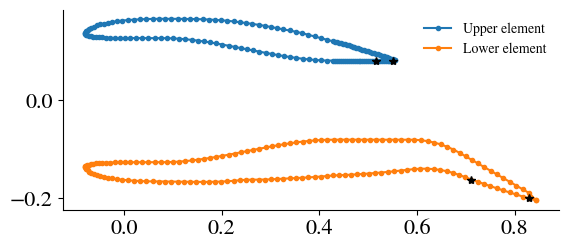

In [4]:
fig = plt.figure()
ax = fig.gca()

# Plot contours
ax.plot([X[0] for X in upper], [X[1] for X in upper], ".-", label="Upper element")
ax.plot([X[0] for X in lower], [X[1] for X in lower], ".-", label="Lower element")

# Put markers at begining of contour to see start and orientation of contour
ax.plot([X[0] for X in upper[[1, 10]]], [X[1] for X in upper[[1, 10]]], "*k")
ax.plot([X[0] for X in lower[[1, 10]]], [X[1] for X in lower[[1, 10]]], "*k")

ax.set_aspect("equal")
ax.legend(loc="best", frameon=False, fontsize=10)
[ax.spines[side].set_visible(False) for side in ["top", "right"]];

Calls `appac2d` using Octave:

In [6]:
%%octave -i surfaces,aoa,CT,xdisk,wakeoptions -o Cp,xc,Cl,Cd,Cm,foils,wakes

% Add appac2d package
addpath(fullfile(pwd, '..'));
addpath(fullfile(pwd, '..', 'mesh2d'));

% Enable GNUPLOT backend for plotting in case it is needed
graphics_toolkit("gnuplot");

% Call panel solver
[Cp, xc, Cl, Cd, Cm, ...
                 foils, wakes] = panel2d(surfaces, aoa, CT, xdisk, wakeoptions, 'Plot','off');

  Cl:  1.57624

  Cd: -0.13324

Cm25: -0.14266

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


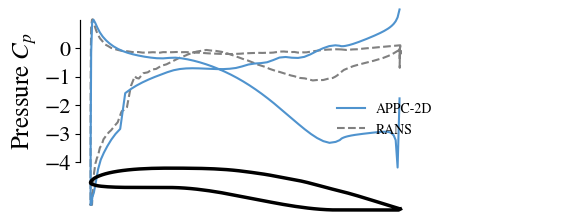

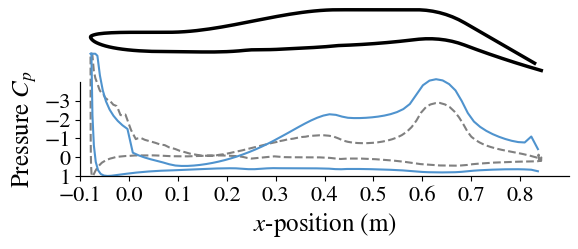

In [9]:
rans_path = "data"                                                  # Where to read RANS data from
rans_file = "jetfoil-111_2N-40ms-30deg-centerlineslice.csv"         # RANS file to read

# Plot each jetfoil element
for upperelement in [True, False]:

    # Fetch indices of panels in this element
    if upperelement:
        indices = range(int(foils.m[0][0]), int(foils.m[0][0]+foils.m[0][1]))
    else: 
        indices = range(0, int(foils.m[0][0]))
    
    # Read RANS data
    data_rans = pd.read_csv(os.path.join(rans_path, rans_file))
    data_rans = data_rans[data_rans['Block Name'] == f"unnamed_block_{0 if upperelement else 1}"]
    
    xs_rans = np.array(data_rans["Points_0"])
    Cps_rans = np.array(data_rans["Cp"])
    
    # Fetch APPC2D data
    xs_appc = np.array(xc.tolist()[1 if upperelement else 0][0]).flatten()
    Cps_appc = np.array(Cp.tolist()[1 if upperelement else 0][0]).flatten()
    
    # Clip data at leading edge
    Cps_rans = [max(Cp, -5.5) for (x, Cp) in zip(xs_rans, Cps_rans)]
    Cps_appc = [max(Cp, -5.5) for (x, Cp) in zip(xs_appc, Cps_appc)]
    
    # Initialize plot
    fig = plt.figure(figsize=np.array([7*1.3, 5*0.8])*2/3)
    ax = fig.gca()
    ax2 = ax.twinx()
    
    # Plot
    ax.plot(xs_rans, Cps_rans, "--", color=clr_rans, label=lbl_rans, clip_on=False)
    ax.plot(xs_appc, Cps_appc, stl_appc, color=clr_appc, label=lbl_appc, clip_on=False)

    # Fetch jetfoil contour
    xs = foils.xo[indices]
    ys = foils.yo[indices]
    
    # Plot jetfoil contour
    ax2.plot(xs, ys, "-", color=clr_geom, linewidth=2.5, alpha=1.0, clip_on=False)
    # ax2.plot(xs[[0, 10]], ys[[0, 10]], "*r", alpha=0.25, clip_on=False)

    # Format twin axis
    ax2.set_aspect(1.0)
    yaux = 0.65
    if upperelement:
        ax2.set_ylim([0, yaux])
    else:
        ax2.set_ylim([-yaux, 0])
    ax2.set_yticks([])

    # Beautify the plot
    xlims, dx = [-0.1, 0.9], 0.1
    ylims, dy = [-4, 1], 1.0
    
    if not upperelement: 
        ylims = [ylims[1], ylims[0]]
        dy *= -1
        
    ax.set_xlim(xlims)
    ax.set_xticks(np.arange(xlims[0], xlims[1], dx))
    ax.set_ylim(ylims)
    ax.set_yticks(np.arange(ylims[0], ylims[1], dy))

    if upperelement:

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1],
                       loc="center left", bbox_to_anchor=(0.5, 0.3), frameon=False, fontsize=10)

        for a in [ax, ax2]:
            a.spines["bottom"].set_visible(False)
            a.set_xticks([])
            
    else:
        ax.set_xlabel(r"$x$-position (m)")
        
    ax.set_ylabel(r"Pressure $C_p$")

    for a in [ax, ax2]:
        a.spines["right"].set_visible(False)
        a.spines["top"].set_visible(False)

    # ax2.plot(xlims, zeros(2), ":k", alpha=0.25, linewidth=1, clip_on=false)


    # fig.tight_layout
    faux = 0.0
    fig.tight_layout(rect=[0.0, 0.0, 1.0, 1.0])

    # Save plots
    # for ext in [".png", ".pdf"]
    #     fig.savefig(figures_path*"/"*out_name*(upperelement ? "-upper" : "-lower")*ext; dpi=300, transparent=true)
    # end